In [1]:
train_path = '/kaggle/input/paddy-disease-classification-2/train_images/'
test_path  = '/kaggle/input/paddy-disease-classification-2/test_images/'

!du --inodes '/kaggle/input/paddy-disease-classification-2/train_images/'
!du --inodes '/kaggle/input/paddy-disease-classification-2/test_images/'

import glob
from pathlib import Path

for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}") 

1562	/kaggle/input/paddy-disease-classification-2/train_images/tungro
614	/kaggle/input/paddy-disease-classification-2/train_images/yellow_stem_borer
1721	/kaggle/input/paddy-disease-classification-2/train_images/hispa
695	/kaggle/input/paddy-disease-classification-2/train_images/downy_mildew
406	/kaggle/input/paddy-disease-classification-2/train_images/black_stem_borer
406	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_leaf_streak
519	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_leaf_blight
1005	/kaggle/input/paddy-disease-classification-2/train_images/brown_spot
1882	/kaggle/input/paddy-disease-classification-2/train_images/blast
877	/kaggle/input/paddy-disease-classification-2/train_images/leaf_roller
1925	/kaggle/input/paddy-disease-classification-2/train_images/normal
361	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_panicle_blight
1020	/kaggle/input/paddy-disease-classification-2/train_images/white_stem_borer
12994

In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


In [3]:
import os
from keras.models import Model
#from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

#https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
#     model.add(Dense(1024))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     model.add(Dense(n_classes))
#     model.add(Activation("softmax"))
    
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

#plot_model(model, '/kaggle/working/model.png', show_shapes=True)

2022-07-18 16:48:08.746258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 16:48:08.925528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 16:48:08.926835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 16:48:08.928754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

channels_last


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
input_shape = (256, 256, 3)

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg16_model = create_model(input_shape, n_classes, optim_2, fine_tune=2)

58900480/58889256 [==============================] - 0s 0us/step


In [6]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
3245


In [7]:
!pip install livelossplot

In [8]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='vgg_model_ft.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

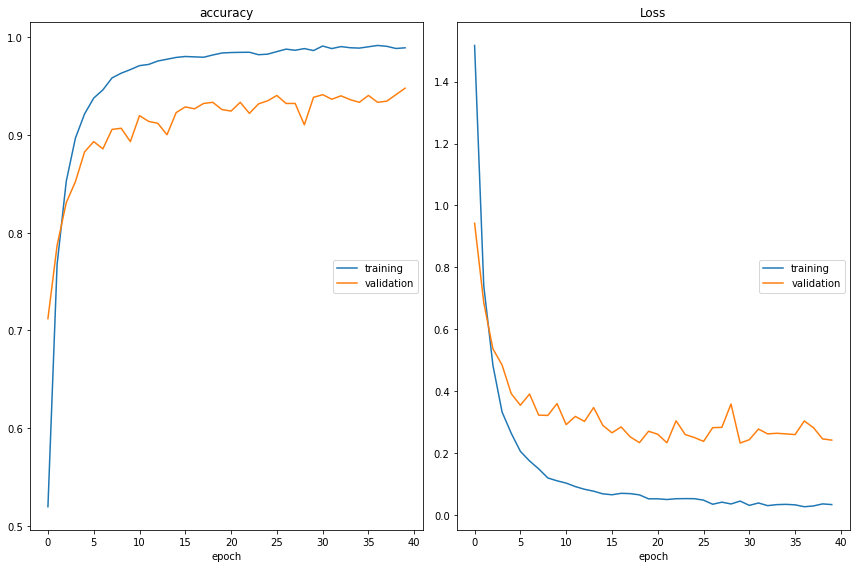

accuracy
	training         	 (min:    0.520, max:    0.992, cur:    0.989)
	validation       	 (min:    0.712, max:    0.948, cur:    0.948)
Loss
	training         	 (min:    0.027, max:    1.517, cur:    0.034)
	validation       	 (min:    0.232, max:    0.942, cur:    0.242)
CPU times: user 2h 52min 53s, sys: 3min 3s, total: 2h 55min 57s
Wall time: 3h 3min 34s


In [9]:
%%time

plot_loss_2 = PlotLossesCallback()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# Retrain model with fine-tuning
vgg16_history = vgg16_model.fit_generator(generator = train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1,epochs=EPOCHS)

In [10]:
# !ls -l /kaggle/input

In [11]:
test_path_new = '/kaggle/input/pd2-test-images-labels/'
!du --inodes '/kaggle/input/pd2-test-images-labels/'

for filepath in glob.glob(test_path_new + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

391	/kaggle/input/pd2-test-images-labels/tungro
153	/kaggle/input/pd2-test-images-labels/yellow_stem_borer
432	/kaggle/input/pd2-test-images-labels/hispa
175	/kaggle/input/pd2-test-images-labels/downy_mildew
102	/kaggle/input/pd2-test-images-labels/black_stem_borer
101	/kaggle/input/pd2-test-images-labels/bacterial_leaf_streak
131	/kaggle/input/pd2-test-images-labels/bacterial_leaf_blight
254	/kaggle/input/pd2-test-images-labels/brown_spot
471	/kaggle/input/pd2-test-images-labels/blast
220	/kaggle/input/pd2-test-images-labels/leaf_roller
482	/kaggle/input/pd2-test-images-labels/normal
91	/kaggle/input/pd2-test-images-labels/bacterial_panicle_blight
255	/kaggle/input/pd2-test-images-labels/white_stem_borer
3259	/kaggle/input/pd2-test-images-labels/
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	

In [12]:
class_subset = sorted(os.listdir(test_path_new))#[:10] # Using only the first 10 classes
class_subset

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'black_stem_borer',
 'blast',
 'brown_spot',
 'downy_mildew',
 'hispa',
 'leaf_roller',
 'normal',
 'tungro',
 'white_stem_borer',
 'yellow_stem_borer']

In [13]:
test_generator_vgg = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path_new,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=class_subset,
    class_mode=None,
    shuffle=False,
    seed=SEED)

vgg16_model.load_weights('vgg_model_ft.weights.best.hdf5') # initialize the best trained weights
# vgg16_model.load_weights('../input/pd2vgg16weightsbest/vgg_model_ft.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg16_model.predict(test_generator_vgg)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

Found 3245 images belonging to 13 classes.


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator_vgg.class_indices.keys()

true_classes = test_generator_vgg.classes

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

cls_report = classification_report(true_classes, vgg_pred_classes_ft, 
                                   target_names=class_names, digits=5)
print(cls_report)

VGG16 Model Accuracy with Fine-Tuning: 93.19%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.85612   0.91538   0.88476       130
   bacterial_leaf_streak    0.93204   0.96000   0.94581       100
bacterial_panicle_blight    1.00000   0.86667   0.92857        90
        black_stem_borer    0.95652   0.87129   0.91192       101
                   blast    0.94017   0.93617   0.93817       470
              brown_spot    0.90310   0.92095   0.91194       253
            downy_mildew    0.95783   0.91379   0.93529       174
                   hispa    0.95792   0.89791   0.92695       431
             leaf_roller    0.99459   0.84018   0.91089       219
                  normal    0.95297   0.96881   0.96082       481
                  tungro    0.84564   0.96923   0.90323       390
        white_stem_borer    0.93585   0.97638   0.95568       254
       yellow_stem_borer    0.98013   0.97368   0.97690       152

                accuracy    

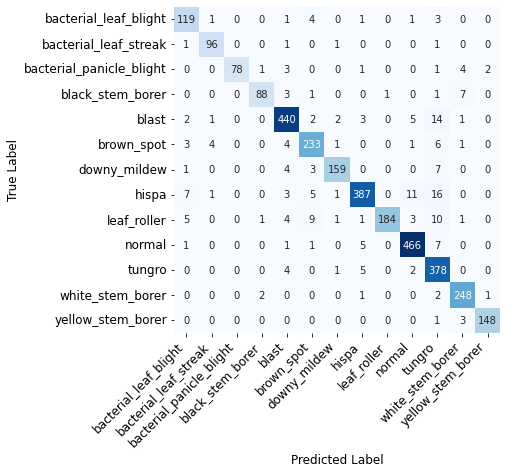

[[119   1   0   0   1   4   0   1   0   1   3   0   0]
 [  1  96   0   0   1   0   1   0   0   0   1   0   0]
 [  0   0  78   1   3   0   0   1   0   0   1   4   2]
 [  0   0   0  88   3   1   0   0   1   0   1   7   0]
 [  2   1   0   0 440   2   2   3   0   5  14   1   0]
 [  3   4   0   0   4 233   1   0   0   1   6   1   0]
 [  1   0   0   0   4   3 159   0   0   0   7   0   0]
 [  7   1   0   0   3   5   1 387   0  11  16   0   0]
 [  5   0   0   1   4   9   1   1 184   3  10   1   0]
 [  1   0   0   0   1   1   0   5   0 466   7   0   0]
 [  0   0   0   0   4   0   1   5   0   2 378   0   0]
 [  0   0   0   2   0   0   0   1   0   0   2 248   1]
 [  0   0   0   0   0   0   0   0   0   0   1   3 148]]


In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator_vgg.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax, title="VGG16")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, vgg_pred_classes_ft)
print(cm)

In [16]:
# %%time
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
# history = model.fit_generator(generator = train_generator,
#                     steps_per_epoch = STEP_SIZE_TRAIN,
#                     validation_data = valid_generator,
#                     validation_steps = STEP_SIZE_VALID,
#                     epochs=EPOCHS)

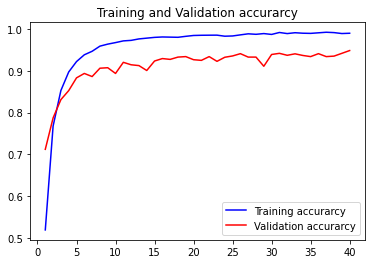

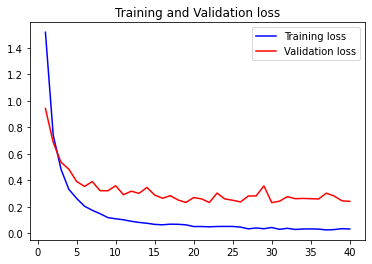

CPU times: user 549 ms, sys: 155 ms, total: 705 ms
Wall time: 465 ms


In [17]:
%%time
history = vgg16_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = vgg16_model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

   6/3245 [..............................] - ETA: 39s 

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3245/3245 [==============================] - 41s 12ms/step


In [19]:
loss, acc = vgg16_model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

   1/3245 [..............................] - ETA: 8:53 - loss: 0.0000e+00 - accuracy: 0.0000e+00

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3245/3245 [==============================] - 27s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [20]:
pd.Series(train_generator.classes).value_counts()

9     1540
4     1505
7     1376
10    1249
11     816
5      804
8      701
6      556
12     491
0      415
1      324
3      324
2      288
dtype: int64

In [21]:
pd.Series(test_generator.classes).value_counts()

0    3245
dtype: int64

In [22]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      489
blast                       468
tungro                      447
hispa                       404
white_stem_borer            265
brown_spot                  258
leaf_roller                 185
downy_mildew                166
yellow_stem_borer           151
bacterial_leaf_blight       139
bacterial_leaf_streak       103
black_stem_borer             92
bacterial_panicle_blight     78
dtype: int64

In [23]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,white_stem_borer
1,200002.jpg,hispa
2,200003.jpg,bacterial_leaf_streak
3,200004.jpg,black_stem_borer
4,200005.jpg,normal
